In [138]:
import yfinance as yf
import yfinance as yf
import pandas as pd

data=pd.read_csv('/content/BOI_7_years_data (1).csv')
data.head()

,Date,Adj Close,Close,High,Low,Open,Volume
0,2017-01-02 00:00:00+00:00,97.877510,107.449997,108.250000,105.750000,107.750000,1948756
1,2017-01-02 00:00:00+00:01,98.697342,108.349998,109.400002,106.650002,107.449997,1945442
2,2017-01-02 00:00:00+00:02,98.105240,107.699997,109.000000,107.250000,108.250000,1551444
3,2017-01-02 00:00:00+00:03,99.790443,109.550003,109.900002,108.199997,108.400002,1681563
4,2017-01-02 00:00:00+00:04,100.701347,110.550003,111.900002,109.699997,109.900002,2126290


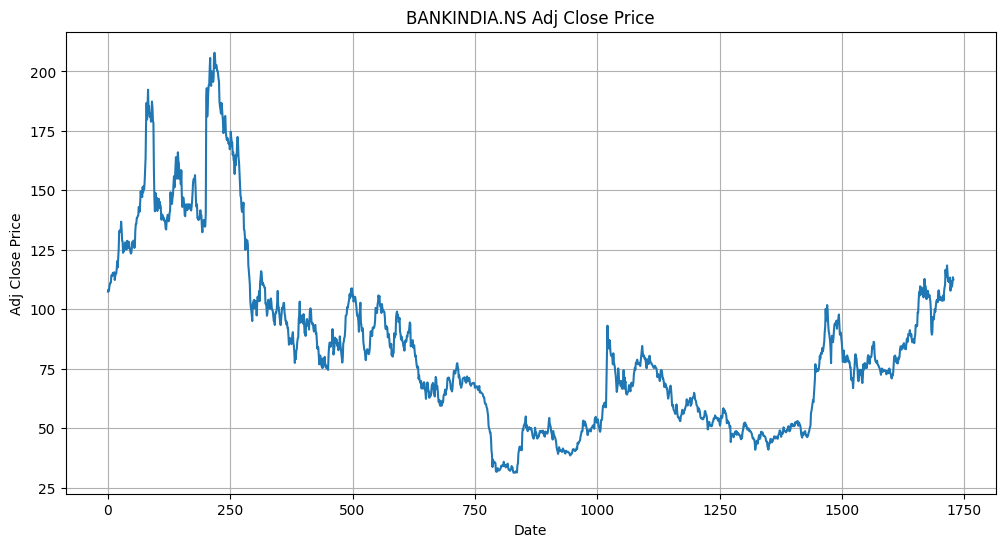

In [139]:
import matplotlib.pyplot as plt

# Assuming 'data' is your DataFrame containing the downloaded data
plt.figure(figsize=(12, 6))
plt.plot(data['Close'])
plt.title(f'{ticker} Adj Close Price')
plt.xlabel('Date')
plt.ylabel('Adj Close Price')
plt.grid(True)
plt.show()


In [142]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Step 1: Data Preprocessing
data = pd.read_csv('/content/BOI_7_years_data (1).csv')
X = data[['Open', 'High', 'Low', 'Close']]
y = data['Close']

print(X.shape)
print(y.shape)

(1729, 4)
(1729,)


In [166]:
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Save the dates before splitting


train_indices=dates[:-5]
test_indices=dates[-5:]

'''X_train=X_scaled[:-5]
y_train=X_scaled[-5:]
X_test=X_scaled[-5:]
y_test=X_scaled[-5:]
'''
X_train, X_test, y_train, y_test,  = train_test_split(
    X_scaled, y,  test_size=0.1, shuffle=False
)

# Extract the corresponding dates for train and test sets using the indices
train_dates = train_indices
test_dates = test_indices


RangeIndex(start=0, stop=246, step=1)


In [167]:
# Step 2: Stacked Autoencoder (SAE)
input_dim = X_train.shape[1]
print(input_dim)
encoding_dim = 32

input_layer = layers.Input(shape=(input_dim,))
encoded = layers.Dense(encoding_dim, activation='relu')(input_layer)
decoded = layers.Dense(input_dim, activation='sigmoid')(encoded)

autoencoder = models.Model(input_layer, decoded)
autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.fit(X_train, X_train, epochs=50, batch_size=32, shuffle=True, validation_data=(X_test, X_test))

encoder = models.Model(input_layer, encoded)
X_train_encoded = encoder.predict(X_train)
X_test_encoded = encoder.predict(X_test)
type( X_train_encoded)

4
Epoch 1/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0822 - val_loss: 0.0193
Epoch 2/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0736 - val_loss: 0.0132
Epoch 3/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0544 - val_loss: 0.0088
Epoch 4/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0362 - val_loss: 0.0043
Epoch 5/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0198 - val_loss: 0.0013
Epoch 6/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0101 - val_loss: 4.6356e-04
Epoch 7/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0052 - val_loss: 1.0499e-04
Epoch 8/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0030 - val_loss: 1.3855e-04
Epoch 9/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0021 - val_loss: 1.9208e-04
Epoch 10/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0016 - val_loss: 2.3812e-04
Epoch 11/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0013 - val_loss: 2.1603e-04
Epoch 12/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/st

numpy.ndarray

In [168]:
# Step 3: Kernel Extreme Learning Machine (KELM)
def polynomial_kernel(X, Y, degree=3, coef0=1):
    return (np.dot(X, Y.T) + coef0) ** degree

def rbf_kernel(X, Y, gamma=0.1):
    if gamma is None:
        gamma = 1.0 / X.shape[1]
    return np.exp(-gamma * np.linalg.norm(X[:, np.newaxis] - Y, axis=2) ** 2)

def sigmoid_kernel(X, Y, coef0=1, gamma=0.1):
    return np.tanh(gamma * np.dot(X, Y.T) + coef0)

class KELM:
    def __init__(self, kernel='rbf', C=1.0, degree=3, gamma=None, coef0=1):
        self.C = C
        self.degree = degree
        self.gamma = gamma
        self.coef0 = coef0
        self.kernel = kernel
        self.alpha_ = None

    def _compute_kernel(self, X, Y):
        if self.kernel == 'polynomial':
            return polynomial_kernel(X, Y, self.degree, self.coef0)
        elif self.kernel == 'rbf':
            return rbf_kernel(X, Y, self.gamma)
        elif self.kernel == 'sigmoid':
            return sigmoid_kernel(X, Y, self.coef0, self.gamma)
        else:
            raise ValueError("Unsupported kernel type")

    def fit(self, X, y):
        y=np.array(y,dtype=float)

        K = self._compute_kernel(X, X)
        N = K.shape[0]
        I = np.identity(N)
        self.alpha_ = np.linalg.inv(I / self.C + K).dot(y)
        self.X_train_ = X

    def predict(self, X):
        K_test = self._compute_kernel(X, self.X_train_)
        return K_test.dot(self.alpha_)

In [169]:
kelm = KELM(kernel='polynomial', C=1.0, gamma=0.1)
kelm.fit(X_train_encoded, y_train)
y_pred = kelm.predict(X_test_encoded)

In [170]:
# Step 4: Evaluation
def mean_absolute_percentage_error(y_true, y_pred):
    y_true=y_true.astype(float)
    y_pred=y_pred.astype(float)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mape = mean_absolute_percentage_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r_squared = r2_score(y_test, y_pred)


print(f"MAPE: {mape:.2f}%")
print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R-squared: {r_squared:.4f}")

MAPE: 0.21%
MAE: 0.1915
RMSE: 0.2462
R-squared: 0.9997


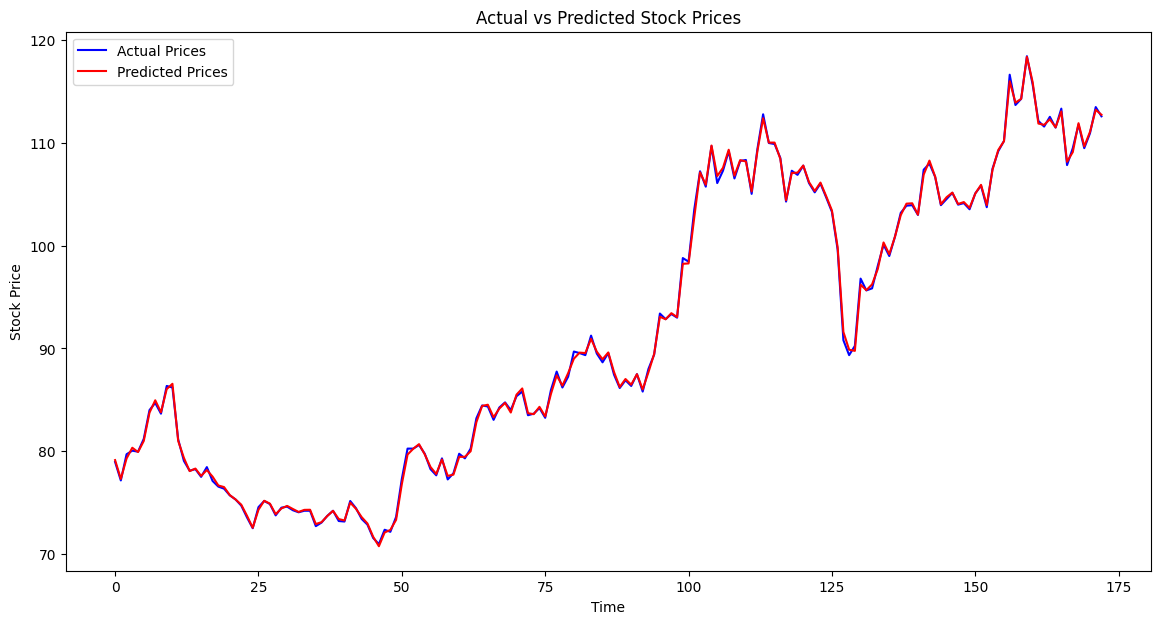

In [171]:
# Step 5: Visualization
plt.figure(figsize=(14, 7))
plt.plot(y_test.values, label='Actual Prices', color='blue')
plt.plot(y_pred, label='Predicted Prices', color='red')
plt.title('Actual vs Predicted Stock Prices')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()


55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


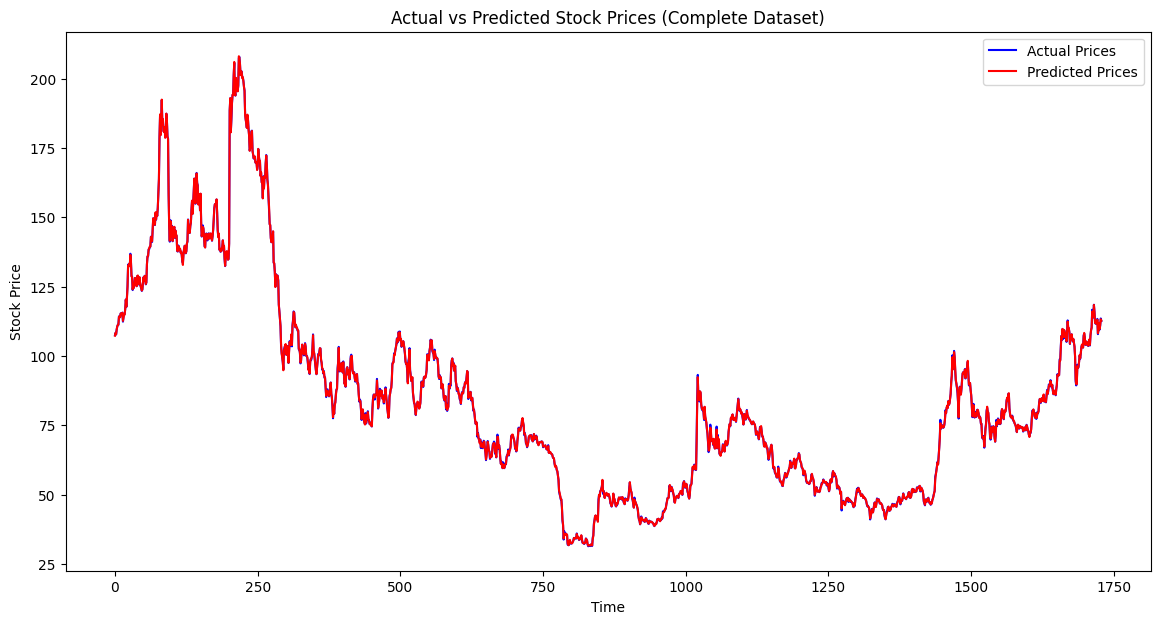

In [172]:
import matplotlib.pyplot as plt
# Get predictions for the entire dataset
X_scaled_all = scaler.transform(X)
X_encoded_all = encoder.predict(X_scaled_all)
y_pred_all = kelm.predict(X_encoded_all)

# Plot the actual and predicted values for the entire dataset
plt.figure(figsize=(14, 7))
plt.plot(y.values, label='Actual Prices', color='blue')
plt.plot(y_pred_all, label='Predicted Prices', color='red')
plt.title('Actual vs Predicted Stock Prices (Complete Dataset)')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

In [173]:

# Function to generate Buy/Sell signals
def get_buy_sell_signals(actual_prices, predicted_prices):
    signals = []
    for i in range(len(actual_prices)):
        if predicted_prices[i] > actual_prices[i]:
            signals.append(f"Buy {predicted_prices[i]} {actual_prices[i]}")
        elif predicted_prices[i] < actual_prices[i]:
            signals.append(f"Sell {predicted_prices[i]} {actual_prices[i]}")

    return signals

# Generate the Buy/Sell signals using actual and predicted prices
signals = get_buy_sell_signals(y_test.values, y_pred)
print(signals[:15])  # Show the first 10 Buy/Sell signals


['Buy 79.13181691782381 78.94999695', 'Buy 77.30110527760155 77.15000153', 'Sell 79.28577670248848 79.69999695', 'Buy 80.33468715142953 80.05000305', 'Sell 79.91506909502863 79.94999695', 'Sell 80.99546976964149 81.19999695', 'Sell 83.75220129803085 84.0', 'Buy 84.95425751985493 84.69999695', 'Buy 83.78987006005423 83.65000153', 'Sell 86.04337741320944 86.34999847', 'Buy 86.55948894640113 86.19999695', 'Sell 81.00216068033245 81.15000153', 'Buy 79.34389602227299 79.05000305', 'Sell 78.05992905910085 78.09999847', 'Buy 78.30674655668844 78.25']


In [174]:
print(y_test.values.shape)
print(y_pred.shape)

(173,)
(173,)


In [175]:
# Function to compute strategy returns
def compute_strategy_returns(actual_prices, predicted_prices, Bc, Sc):
    returns = 0
    for t in range(len(actual_prices) - 1):
        if predicted_prices[t + 1] > actual_prices[t]:  # Buy signal
            returns += (predicted_prices[t + 1] - actual_prices[t] + (actual_prices[t] * Bc + predicted_prices[t + 1] * Sc)) / actual_prices[t]
        else:  # Sell signal
            returns += (actual_prices[t] - predicted_prices[t + 1] + (predicted_prices[t + 1] * Bc + actual_prices[t] * Sc)) / actual_prices[t]
    return 100 * returns

# Compute strategy returns
strategy_returns = compute_strategy_returns(y_test.values, y_pred, Bc=0.001, Sc=0.001)
print("Strategy Returns:", strategy_returns)

Strategy Returns: 302.7185100790496
